In [1]:
import numpy as np
import pysindy as ps
import timeit
from scipy.optimize import minimize
from scipy.interpolate import interp2d 
from matplotlib import pyplot as plt
from matplotlib import collections
import os
from shutil import rmtree
from IPython.display import Video
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

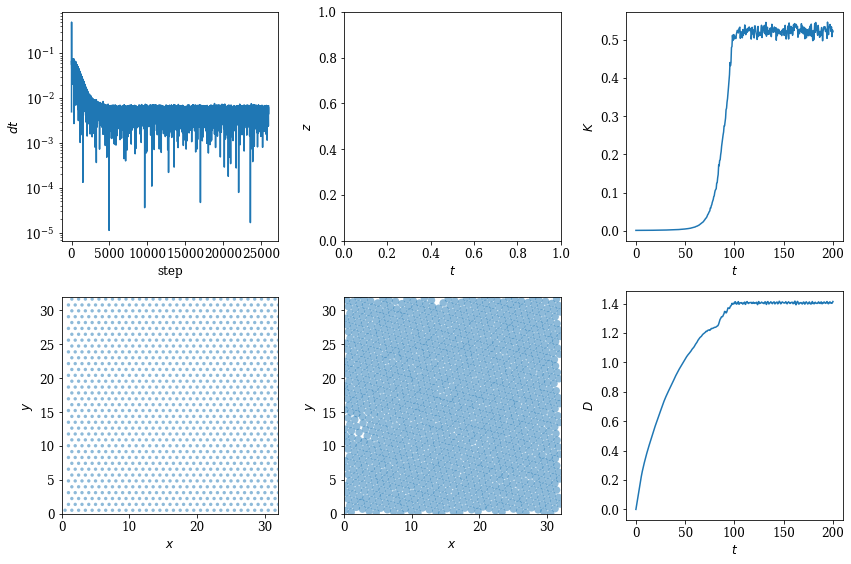

In [2]:
filebase='data/quasistatic'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
dmax=5 #add to output
# bins=int(len(order)**0.5)
# order=order.reshape((bins,bins))*L*L/(N*N)/len(states)/(2*dmax/bins*2*dmax/bins)

plt.subplots(2,3,figsize=(12,8))
plt.subplot(2,3,1)
plt.ylabel('$dt$')
plt.xlabel('step')
plt.yscale('log')
plt.plot(np.diff(times))
plt.subplot(2,3,2)
plt.ylabel('$z$')
plt.xlabel('$t$')
# plt.plot(dt*np.arange(len(coords)),coords)
plt.subplot(2,3,4)
t=t3
Rt=R
if t<t2:
    Rt=R0+t/t2*(R-R0)
circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(states[0,0::4],states[0,1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

plt.subplot(2,3,5)
t=t1
Rt=R
if t<t2:
    Rt=R0+t/t2*(R-R0)
circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(states[-1,0::4],states[-1,1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

plt.subplot(2,3,3)
plt.xlabel('$t$')
plt.ylabel('$K$')
plt.plot(dt*np.arange(len(states)),np.mean(0.5*(states[:,2::4]**2+states[:,3::4]**2),axis=1))

plt.subplot(2,3,6)
plt.xlabel('$t$')
plt.ylabel('$D$')
plt.plot(dt*np.arange(len(states)), np.mean((np.mod(states[:,0::4]-states[0,0::4]+L/2,L)-L/2)**2+(np.mod(states[:,1::4]-states[0,1::4]+L/2,L)-L/2)**2,axis=1)**0.5)


plt.tight_layout()
plt.show()

In [4]:
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    t=t3+skip*i*(t1-t3)/int(len(states)/skip)
    Rt=R
    if t<t2:
        Rt=R0+t/t2*(R-R0)
    circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(states[skip*i,0::4],states[skip*i,1::4])]
    circles2 = [plt.Circle((x,y), radius=R0) for (x,y) in zip(states[skip*i,0::4],states[skip*i,1::4])]
    plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
    plt.gca().add_collection(collections.PatchCollection(circles2,fc='red',alpha=0.5))
    plt.xlim(0,L)
    plt.ylim(0,L)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.gca().set_aspect(1)
    plt.savefig(filebase+'animation/'+str(i).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 15 ')
rmtree(filebase+'animation')
Video(filebase+'animation.mp4',width=512)

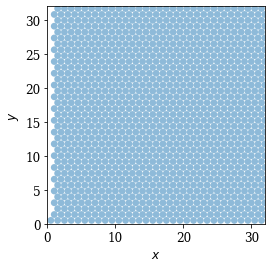

In [47]:
N=1166
R=0.5
V=1.0
L=32
xs=[]
ys=[]
x=R
y=R
for i in range(N):
    xs.append(x)
    ys.append(y)
    x=x+2*R
    if(x>L):
        y=y+3**0.5*R
        x=np.mod(x+R,L)

circles = [plt.Circle((x,y), radius=R) for (x,y) in zip(xs,ys)]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

for i in range(100):
    ic=np.concatenate(np.array([xs,ys,V*(np.random.random(N)-0.5),V*(np.random.random(N)-0.5)]).T)
    ic.tofile('data/sweep2/'+str(i)+'ic.dat')

## 1d SiNDY

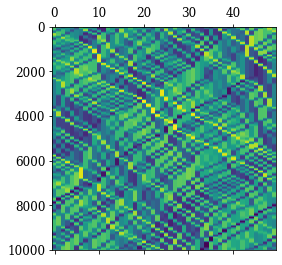

In [5]:
filebase='data/1d'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
for i in range(int(N/4)):
    states[:,2*i]=np.mod(states[:,2*i]+L/2,L)-L/2
for i in range(int(3*N/4),N):
    states[:,2*i]=np.mod(states[:,2*i]-L/2,L)+L/2
    
plt.matshow(states[:,1::2],aspect=len(states[0])/len(states)/2)
plt.show()

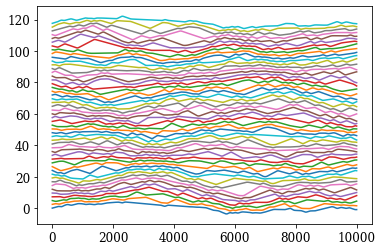

/home/zackn/.conda/envs/oscillator_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/zackn/.conda/envs/oscillator_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/home/zackn/.conda/envs/oscillator_env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

x0' = 1.000 f1(x1)
x1' = 9.999 f0(x0,x2) + 9.999 f0(x0,x98)
x2' = 1.000 f1(x3)
x3' = -9.999 f0(x0,x2) + 9.999 f0(x2,x4)
x4' = 1.000 f1(x5)
x5' = -9.999 f0(x2,x4) + 9.999 f0(x4,x6)
x6' = 1.000 f1(x7)
x7' = -9.999 f0(x4,x6) + 9.999 f0(x6,x8)
x8' = 1.000 f1(x9)
x9' = -9.999 f0(x6,x8) + 9.999 f0(x8,x10)
x10' = 1.000 f1(x11)
x11' = -9.999 f0(x8,x10) + 9.999 f0(x10,x12)
x12' = 1.000 f1(x13)
x13' = -9.999 f0(x10,x12) + 9.999 f0(x12,x14)
x14' = 1.000 f1(x15)
x15' = -9.999 f0(x12,x14) + 9.999 f0(x14,x16)
x16' = 1.000 f1(x17)
x17' = -9.999 f0(x14,x16) + 9.999 f0(x16,x18)
x18' = 1.000 f1(x19)
x19' = -9.999 f0(x16,x18) + 9.999 f0(x18,x20)
x20' = 1.000 f1(x21)
x21' = -9.999 f0(x18,x20) + 9.999 f0(x20,x22)
x22' = 1.000 f1(x23)
x23' = -9.999 f0(x20,x22) + 9.999 f0(x22,x24)
x24' = 1.000 f1(x25)
x25' = -9.999 f0(x22,x24) + 9.999 f0(x24,x26)
x26' = 1.000 f1(x27)
x27' = -9.999 f0(x24,x26) + 9.999 f0(x26,x28)
x28' = 1.000 f1(x29)
x29' = -9.999 f0(x26,x28) + 9.999 f0(x28,x30)
x30' = 1.000 f1(x31)
x31' = -9

In [4]:
filebase='data/1d'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
for i in range(int(N/4)):
    states[:,2*i]=np.mod(states[:,2*i]+L/2,L)-L/2
for i in range(int(3*N/4),N):
    states[:,2*i]=np.mod(states[:,2*i]-L/2,L)+L/2

icoord=[]
jcoord=[]
ind=0
while ind<len(order):
    icoord.append(order[ind+1:ind+2*order[ind]+1:2])
    jcoord.append(order[ind+2:ind+2*order[ind]+1:2])
    ind=ind+2*order[ind]+1
coords= np.array([len(ind) for ind in icoord])/(N/2)
plt.plot(states[:,::2])
plt.show()

def iden (x):
    return x
def pairwise (x,y):
    d=np.mod(x-y+L/2,L)-L/2
    return [ np.sign(d[i])*(1-np.linalg.norm(d[i])/(2*R))**1.5 if np.linalg.norm(d[i])<2*R else 0 for i in range(len(d)) ]

states.shape
library_functions = [pairwise,iden]
custom_library = ps.CustomLibrary(library_functions=library_functions)
model = ps.SINDy(feature_library=custom_library)
start=timeit.default_timer()
model.fit(states, t=np.arange(0,len(states))*dt)
stop=timeit.default_timer()
model.print()
print(stop-start)

In [5]:
N=50
L=120
V=1.0
vel=2*V*(np.random.random(N)-0.5)
ic=np.transpose([np.arange(N)*L/N,vel-np.mean(vel)]).reshape((2*N))
ic.tofile('data/1dic.dat')

In [6]:
skip=10
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    circles=[plt.Circle((x,0),radius=R) for x in states[i*skip, ::2]]
    plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
    plt.xlim(0,L)
    plt.ylim(-L/2,L/2)
    plt.gca().set_aspect(1)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.savefig(filebase+'animation/'+str(i).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 15 ')
rmtree(filebase+'animation')
Video(filebase+'animation.mp4',width=512)

### 1d coarse graining

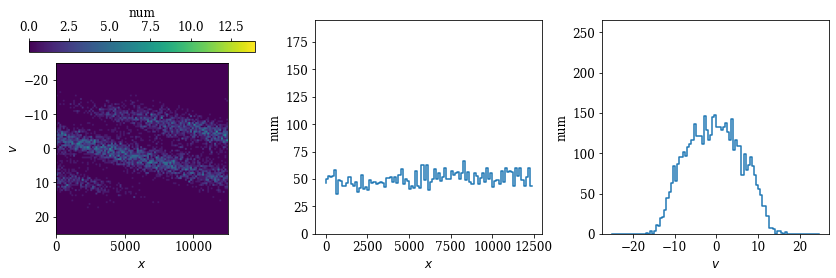

In [218]:
filebase='data/ensemble/8'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H,dmax=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)

file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
states2=states.reshape((states.shape[0],int(states.shape[1]/2),2))

nbins=100
skip=1
histograms=[]
vmax=25
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    hist,bins=np.histogramdd(states2[skip*i],bins=(np.arange(0,L+L/nbins,L/nbins),np.arange(-vmax,vmax+2*vmax/nbins,2*vmax/nbins)))
    histograms.append(hist)
np.save(filebase+'histograms',histograms)

nmax=np.max(histograms)
nmaxv=np.max(np.sum(histograms,axis=1))
nmaxx=np.max(np.sum(histograms,axis=2))
i=-1

plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
hist,bins=np.histogramdd(states2[i],bins=(np.arange(0,L+L/nbins,L/nbins),np.arange(-vmax,vmax+2*vmax/nbins,2*vmax/nbins)))
plt.imshow(hist.T,vmin=0,vmax=nmax,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nbins),np.sum(hist,axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/nbins),np.sum(hist,axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

In [209]:
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    circles=[plt.Circle((x,0),radius=R) for x in states[i*skip, ::2]]
    plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
    plt.xlim(L/2-L/2/100,L/2+L/2/100)
    plt.ylim(-L/2/100,L/2/100)
    plt.gca().set_aspect(1)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.savefig(filebase+'animation/'+str(i).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 30 ')
rmtree(filebase+'animation')

In [213]:
Video(filebase+'animation.mp4',width=800)

In [211]:
skip=1
if os.path.isdir(filebase+'histogram'):
    rmtree(filebase+'histogram')
if not os.path.isdir(filebase+'histogram'):
    os.mkdir(filebase+'histogram')
    
for i in range(0,len(states),skip):
    print(i, len(states),end='\r')
    plt.subplots(1,3,figsize=(12,4))
    plt.subplot(1,3,1)
    hist,bins=np.histogramdd(states2[i],bins=(np.arange(0,L+L/nbins,L/nbins),np.arange(-vmax,vmax+2*vmax/nbins,2*vmax/nbins)))
    plt.imshow(hist.T,vmin=0,vmax=nmax,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(1,3,2)
    plt.step(np.arange(0,L,L/nbins),np.sum(hist,axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(1,3,3)
    plt.step(np.arange(-vmax,vmax,2*vmax/nbins),np.sum(hist,axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    plt.tight_layout()
    plt.savefig(filebase+'histogram/'+str(int(i/skip)).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'histogram/' + ' '  + filebase+'histogram 30 ')
rmtree(filebase+'histogram')

In [214]:
Video(filebase+'histogram.mp4',width=800)

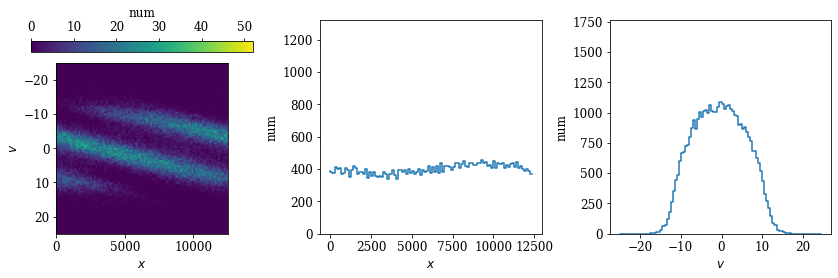

In [219]:
histograms=np.sum([np.load('data/ensemble/'+str(i)+'histograms.npy') for i in range(1,9)],axis=0)
nmax=np.max(histograms)
nmaxv=np.max(np.sum(histograms,axis=1))
nmaxx=np.max(np.sum(histograms,axis=2))

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(histograms[i].T,vmin=0,vmax=nmax,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nbins),np.sum(histograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/nbins),np.sum(histograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

In [220]:
filebase='data/ensemble/histograms'
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(0,len(states),skip):
    print(i, len(states),end='\r')
    plt.subplots(1,3,figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(histograms[i].T,vmin=0,vmax=nmax,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(1,3,2)
    plt.step(np.arange(0,L,L/nbins),np.sum(histograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(1,3,3)
    plt.step(np.arange(-vmax,vmax,2*vmax/nbins),np.sum(histograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    plt.tight_layout()
    plt.savefig(filebase+'animation/'+str(int(i/skip)).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 30 ')
rmtree(filebase+'animation')

In [221]:
Video(filebase+'animation.mp4',width=800)

In [222]:
print(np.array(histograms).shape)
np.save('data/ensemble/histograms.npy',histograms)

(1001, 100, 100)


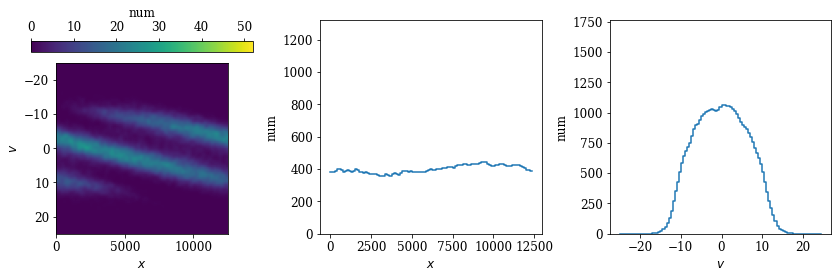

In [223]:
from scipy.signal import convolve2d

histograms=np.load('data/ensemble/histograms.npy')
nt,nx,nv=histograms.shape
smoothhistograms=np.zeros((nt,nx,nv))

sigma=1
kernel=np.outer(np.exp(-(np.mod(np.arange(nx)+nx/2,nx)-nx/2)**2/(2*sigma**2)),np.exp(-(np.mod(np.arange(nv)+nv/2,nv)-nv/2)**2/(2*sigma**2)))/(2*np.pi*sigma**2)
kernel=np.roll(np.roll(kernel,int(nx/2),axis=0),int(nv/2),axis=1)
for i in range(nt):
    print(i,end='\r')
    smoothhistograms[i]=convolve2d(kernel,histograms[i],mode='same',boundary='wrap')

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(smoothhistograms[i].T,vmin=0,vmax=nmax,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nbins),np.sum(smoothhistograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/nbins),np.sum(smoothhistograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

In [224]:
filebase='data/ensemble/smoothhistograms'
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(0,len(states),skip):
    print(i, len(states),end='\r')
    plt.subplots(1,3,figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(smoothhistograms[i].T,vmin=0,vmax=nmax,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(1,3,2)
    plt.step(np.arange(0,L,L/nbins),np.sum(smoothhistograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(1,3,3)
    plt.step(np.arange(-vmax,vmax,2*vmax/nbins),np.sum(smoothhistograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    plt.tight_layout()
    plt.savefig(filebase+'animation/'+str(int(i/skip)).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 30 ')
rmtree(filebase+'animation')

In [225]:
Video(filebase+'animation.mp4',width=800)

In [226]:
print(np.array(smoothhistograms).shape)
np.save('data/ensemble/smoothhistograms.npy',smoothhistograms)

(1001, 100, 100)


## two particle distributions

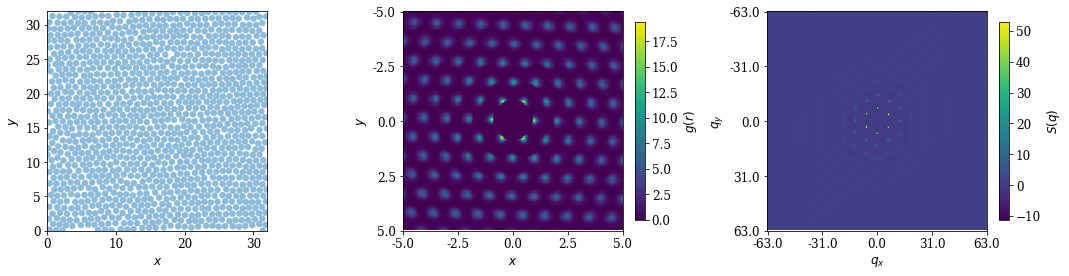

In [3]:
filebase='data/structure/9'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
fs=np.fromfile(filebase+'fs.dat')
dmax=5 #add to output
bins=int(len(order)**0.5)
order=order.reshape((bins,bins))*L*L/(N*N)/(2*dmax/bins*2*dmax/bins)/((t1-t3)/dt)

fig,axs=plt.subplots(1,3,figsize=(15,4))
plt.subplot(1,3,1)
t=t1
Rt=R
if t<t2:
    Rt=R0+t/t2*(R-R0)
circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(fs[0::4],fs[1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

ax=plt.subplot(1,3,2)
xs=-dmax+2*dmax*np.arange(bins)/bins
ys=-dmax+2*dmax*np.arange(bins)/bins
zs=order
labs=(-0.5+np.arange(5)/4)*dmax*2
tics=(np.arange(5)/4)*bins
pcm=ax.matshow(zs)
plt.xticks(tics,labs)
plt.yticks(tics,labs)
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.xaxis.tick_bottom()
fig.colorbar(pcm,fraction=0.04,label='$g(r)$',ax=ax)

ax=plt.subplot(1,3,3)
qxs=2*np.pi*bins/(2*dmax)*(-0.5+np.arange(bins)/bins)
qys=2*np.pi*bins/(2*dmax)*(-0.5+np.arange(bins)/bins)
qzs=np.roll(np.roll(1+N/(L*L)*(2*dmax/bins)**2*np.real(np.fft.fft2(np.roll(np.roll(order-1,int(bins/2),axis=0),int(bins/2),axis=1))),int(bins/2),axis=0),int(bins/2),axis=1)
labs=np.round((-0.5+np.arange(5)/4)*2*np.pi*bins/(2*dmax))
tics=(np.arange(5)/4)*bins
pcm=ax.matshow(qzs)
plt.xticks(tics,labs)
plt.yticks(tics,labs)
plt.xlabel('$q_x$')
plt.ylabel('$q_y$')
ax.xaxis.tick_bottom()
plt.colorbar(pcm,fraction=0.04,label='$S(q)$',ax=ax)

plt.tight_layout()
plt.savefig(filebase+'structure.pdf')
plt.show()

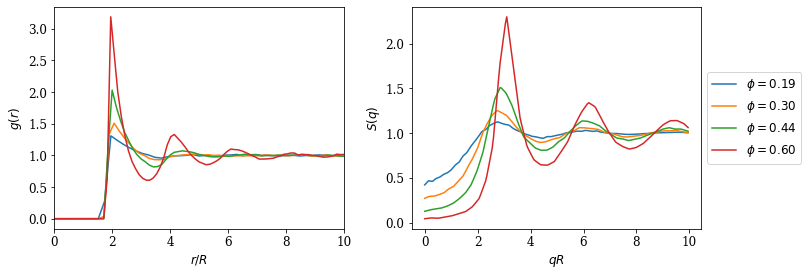

In [7]:
plt.subplots(1,2,figsize=(10,4))
for i in [1,3,5,7]:
    filebase='data/structure/'+str(i)
    file=open(filebase+'out.dat')
    N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
    N=int(N)
    dim=int(dim)
    L=float(L)
    R0=float(R0)
    R=float(R)
    t1=float(t1)
    t2=float(t2)
    t3=float(t3)
    dt=float(dt)
    file.close()
    order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
    bins=int(len(order)**0.5)
    order=order.reshape((bins,bins))*L*L/(N*N)/(2*dmax/bins*2*dmax/bins)/((t1-t3)/dt)

    plt.subplot(1,2,1)
    xs=-dmax+2*dmax*np.arange(bins)/bins
    ys=-dmax+2*dmax*np.arange(bins)/bins
    zs=order
    fun=interp2d(xs,ys,zs)
    thetas=np.arange(bins)*2*np.pi
    rs=np.arange(bins)/bins*dmax
    gs=np.array([np.mean([fun(r*np.cos(theta),r*np.sin(theta)) for theta in thetas]) for r in rs])
    plt.xlabel('$r/R$')
    plt.ylabel('$g(r)$')
    plt.xlim(0,10)
    plt.plot(rs/R,gs)
    
    ax=plt.subplot(1,2,2)
    qxs=2*np.pi*bins/(2*dmax)*(-0.5+np.arange(bins)/bins)
    qys=2*np.pi*bins/(2*dmax)*(-0.5+np.arange(bins)/bins)
    qzs=np.roll(np.roll(1+N/(L*L)*(2*dmax/bins)**2*np.real(np.fft.fft2(np.roll(np.roll(order-1,int(bins/2),axis=0),int(bins/2),axis=1))),int(bins/2),axis=0),int(bins/2),axis=1)
    fun=interp2d(qxs,qys,qzs)
    qs=np.arange(bins)/bins*10/R
    Ss=np.array([np.mean([fun(q*np.cos(theta),q*np.sin(theta)) for theta in thetas]) for q in qs])
    plt.xlabel('$qR$')
    plt.ylabel('$S(q)$')
    plt.plot(qs*R,Ss,label='$\phi=%.2f$'%(N*np.pi*R**2/(L*L)))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('structures.pdf',bbox_inches="tight")

plt.show()

0.5833532093527128


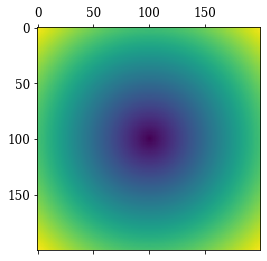

In [36]:
rads=np.zeros((bins,bins))
for i in range(bins):
    for j in range(bins):
        x=(i-int(bins/2))/bins*2*dmax
        y=(j-int(bins/2))/bins*2*dmax
        rads[i,j]=(x**2+y**2)**0.5
plt.matshow(rads)
coord=np.sum(order[np.where(rads<2*R)])/(L*L/(N*N)/(2*dmax/bins*2*dmax/bins))/N
print(coord)